# Task 1: Hose Price Prediction

***Problem Statement*** : Predicting the housing price based on certain factors such as house area, number of bedrooms, furnishing, distance from mainroad.

***Objective*** :

* Understand the Dataset & cleanup (if required).
* Build Regression models to predict the sales w.r.t a single & multiple feature.
* Also evaluate the models & compare thier respective scores like R2, RMSE, etc.

***Dataset***:

The dataset used is [Housing Price Dataset]('https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data') from Kaggle. The dataset is small yet, it's complexity arises due to the fact that it has strong multicollinearity.

***Methodology***:

The following steps are adapted to perform the prediction of housing price:

1. Data collection and exploration
2. Data Preparation
3. Data Manipulation
4. Feature Engineering
5. Model training
6. Model Evaluation and Interpretation

## 1. Data Collection and Exploration

This step involves loading of dataset and exploring data and columns.

In [36]:
# Import modules

# os module for file operations
import os
# Modules for Data Manipulation
import math
import numpy as np
import pandas as pd
# Modules for Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

# Sckit-learn module for Model building
from statsmodels.formula import api
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Module for Feature Engineering
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# load the dataset
df = pd.read_csv('Housing_data.csv')
original_data = df.copy(deep=True)
# Display top 5 data rows
df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


From the pricing data we observe the values are continous, thus its a regression problem. We will need a regressor model to predict prices

In [3]:
# explore the columns in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [4]:
# Choose features and target of the model 
target = 'price'
features = [i for i in df.columns if i not in [target]]

# Extract features data
data = df[features]

print('The Datset consists of {} columns & {} samples.\n'.format(df.shape[1], df.shape[0]))
print('Features: {}\n'.format(features))
print('Target:', target)

The Datset consists of 13 columns & 545 samples.

Features: ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']

Target: price


In [5]:
# Segregate into Numeric and Categorical features 
categorical_features =  ['mainroad','guestroom','basement','hotwaterheating','airconditioning','prefarea','furnishingstatus', 'bedrooms', 'bathrooms', 'stories', 'parking']
numerical_features = ['price', 'area']

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)

Categorical features: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus', 'bedrooms', 'bathrooms', 'stories', 'parking']
Numerical features: ['price', 'area']


## 2. Data Preparation 

This step aims to clean the data by handling missing values, outliers, and inconsistencies, normalizing numeric features and converting categorical data (like location) into numerical representations using techniques such as one-hot encoding or label encoding.

### a. Handle Missing Data



In [6]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64


In [7]:
# Check for duplicate values
df.duplicated().sum()

0

From above analysis, we can conclude that dataset is free of missing values and duplicates. 

### b. Exploratory Data Analysis (EDA)

In EDA, the aim is to perform activities such as data visualization, summary statistics, correlation analysis, and data distribution analysis.

In [8]:
# Compute summary statistics of all the columns
print(df.describe())

              price          area    bedrooms   bathrooms     stories  \
count  5.450000e+02    545.000000  545.000000  545.000000  545.000000   
mean   4.766729e+06   5150.541284    2.965138    1.286239    1.805505   
std    1.870440e+06   2170.141023    0.738064    0.502470    0.867492   
min    1.750000e+06   1650.000000    1.000000    1.000000    1.000000   
25%    3.430000e+06   3600.000000    2.000000    1.000000    1.000000   
50%    4.340000e+06   4600.000000    3.000000    1.000000    2.000000   
75%    5.740000e+06   6360.000000    3.000000    2.000000    2.000000   
max    1.330000e+07  16200.000000    6.000000    4.000000    4.000000   

          parking  
count  545.000000  
mean     0.693578  
std      0.861586  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      3.000000  


In [9]:
# display types of features
print(df.dtypes)

price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object


In [10]:
# Check number of unique rows in each feature
df[features].nunique().sort_values()

mainroad              2
guestroom             2
basement              2
hotwaterheating       2
airconditioning       2
prefarea              2
furnishingstatus      3
bathrooms             4
stories               4
parking               4
bedrooms              6
area                284
dtype: int64

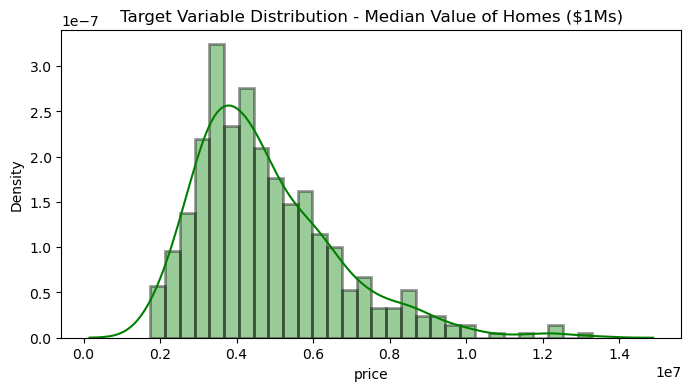

In [11]:
# Plot to analyse the distribution of target variable
plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

                                 Categorical Features Distribution:                                 


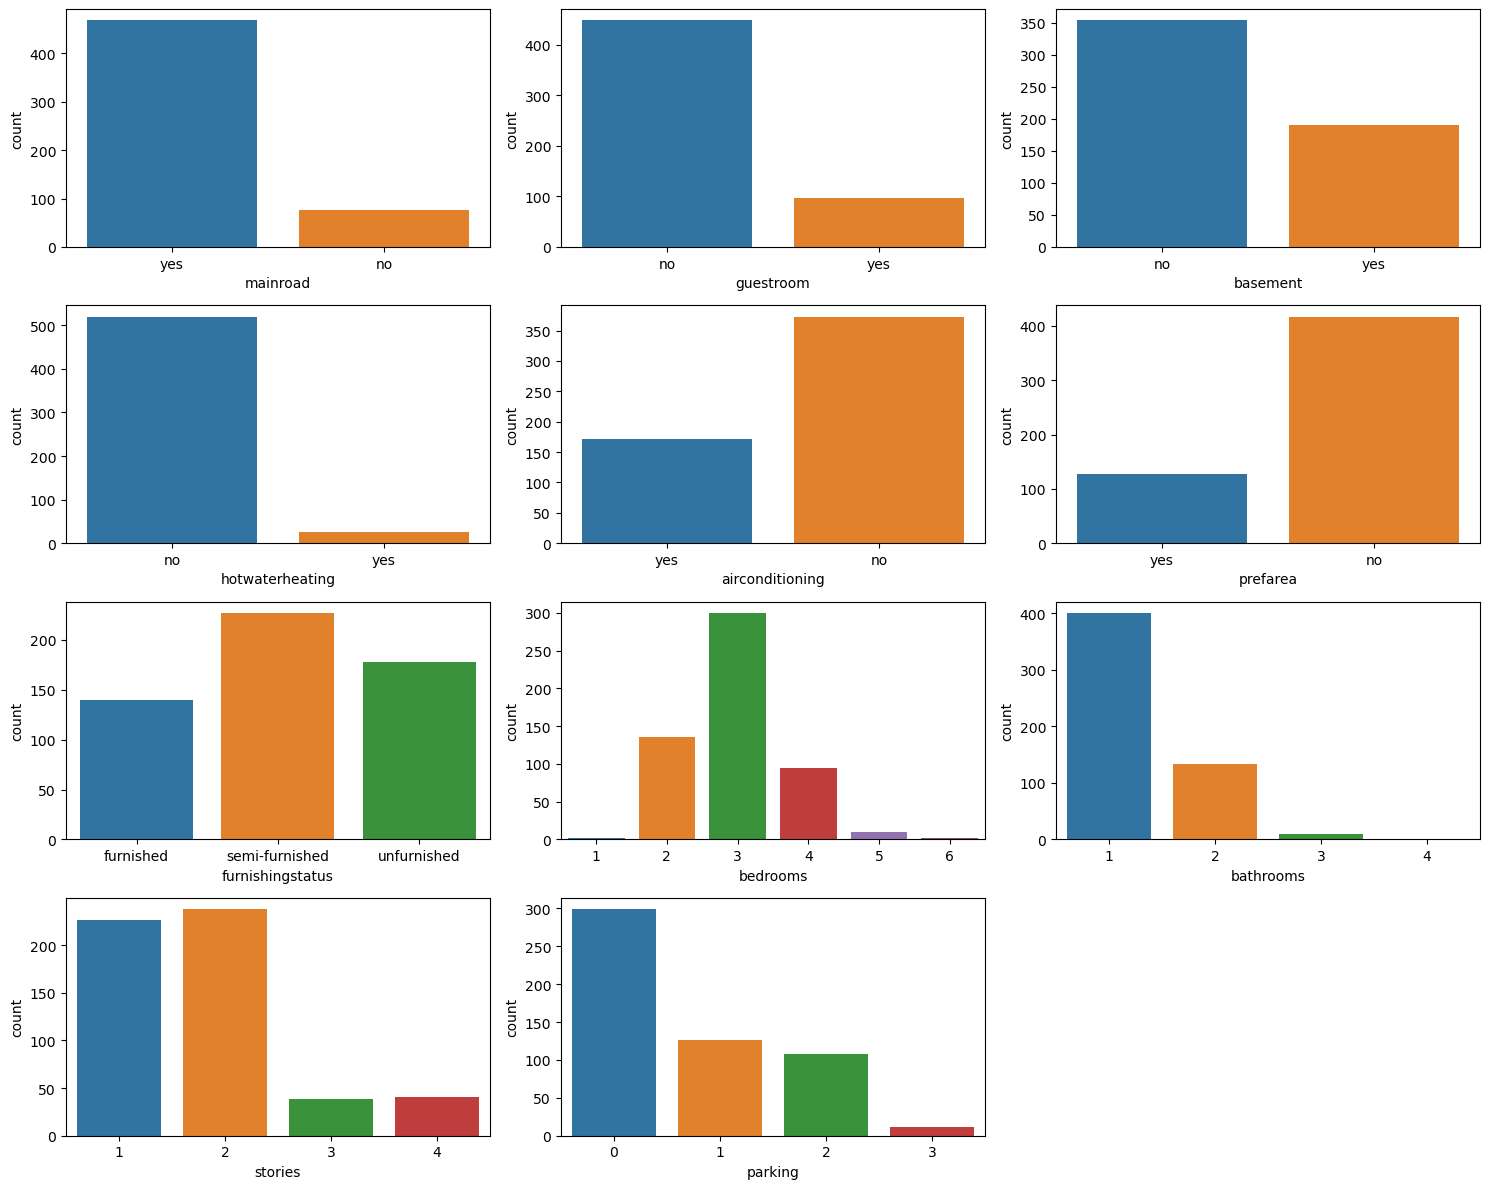

In [12]:
#Visualising the categorical features 
print('Categorical Features Distribution:'.center(100))

n=3
plt.figure(figsize=[15,3*math.ceil(len(categorical_features)/n)])

for i in range(len(categorical_features)):
    plt.subplot(math.ceil(len(categorical_features)/3),n,i+1)
    if pd.api.types.is_categorical_dtype(df[categorical_features[i]]):
        sns.catplot(data=df, x=categorical_features[i], y='price', kind='bar')
    else:
        sns.countplot(data=df, x=categorical_features[i])
        
plt.tight_layout()
plt.show()


                                  Numerical Features Distribution:                                  


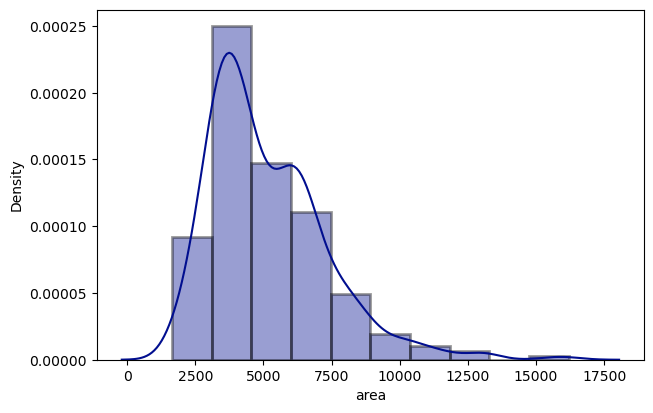

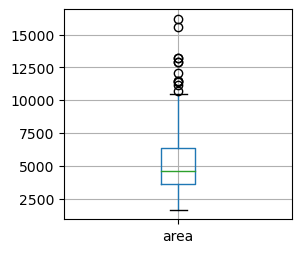

In [13]:
#Visualising the numerical features 
print('Numerical Features Distribution:'.center(100))

plt.figure(figsize=[24,10])
plt.subplot(2,3,1)
sns.distplot(df['area'],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.show()

plt.subplot(2,3,1)
df.boxplot('area')
plt.show()

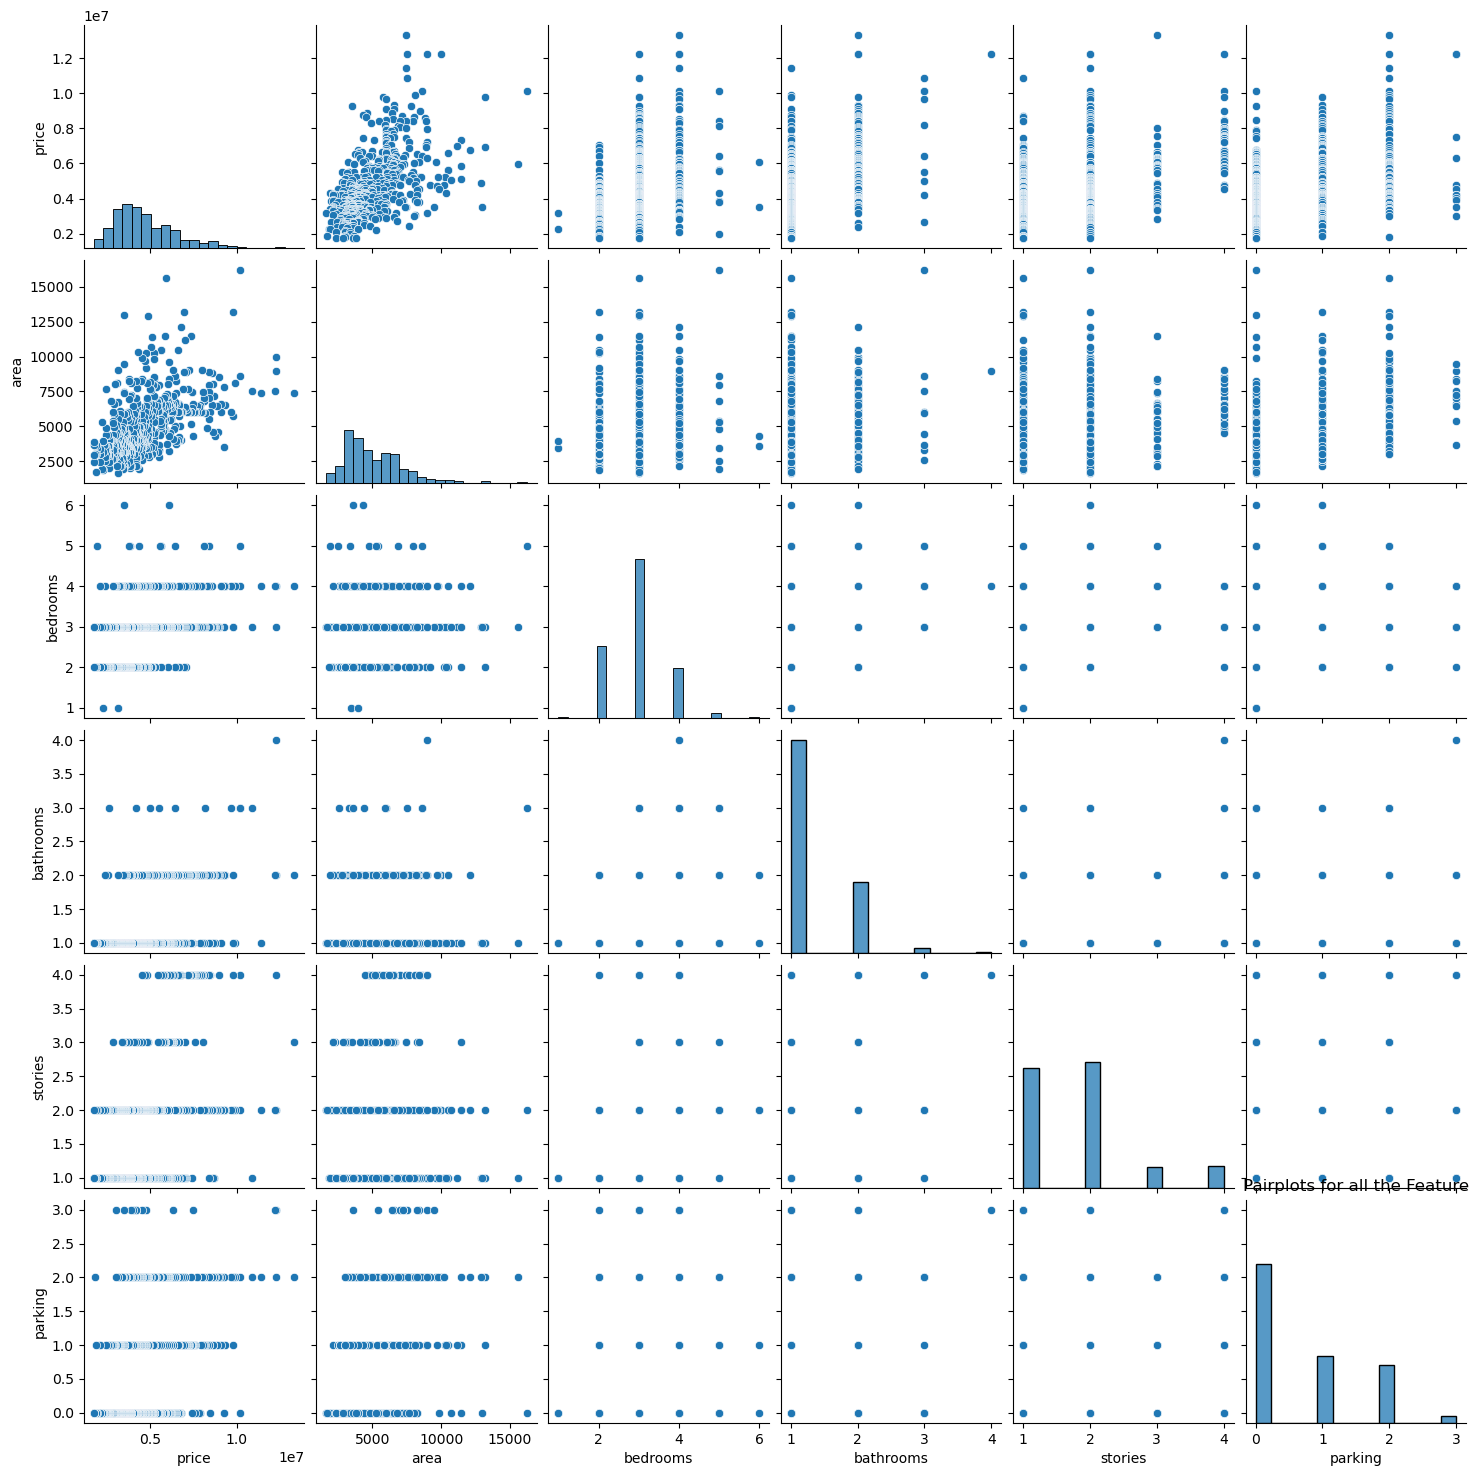

In [14]:
#Understanding the relationship between all the features
num_feature = []
for col in df.columns:
    if df[col].dtype.name != 'object':
        num_feature.append(col)

df_num = df[num_feature]
sns.pairplot(df_num)
plt.title('Pairplots for all the Feature')
plt.show()

### c. Handling Categorical Features

In [15]:
# One-hot encoding for Categorical features
lb = LabelEncoder()
for feature in categorical_features:
    df[feature] = lb.fit_transform(df[feature])
    
df.head(5)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,3,1,2,1,0,0,0,1,2,1,0
1,12250000,8960,3,3,3,1,0,0,0,1,3,0,0
2,12250000,9960,2,1,1,1,0,1,0,0,2,1,1
3,12215000,7500,3,1,1,1,0,1,0,1,3,1,0
4,11410000,7420,3,0,1,1,1,1,0,1,2,0,0


### d. Handling Outliers



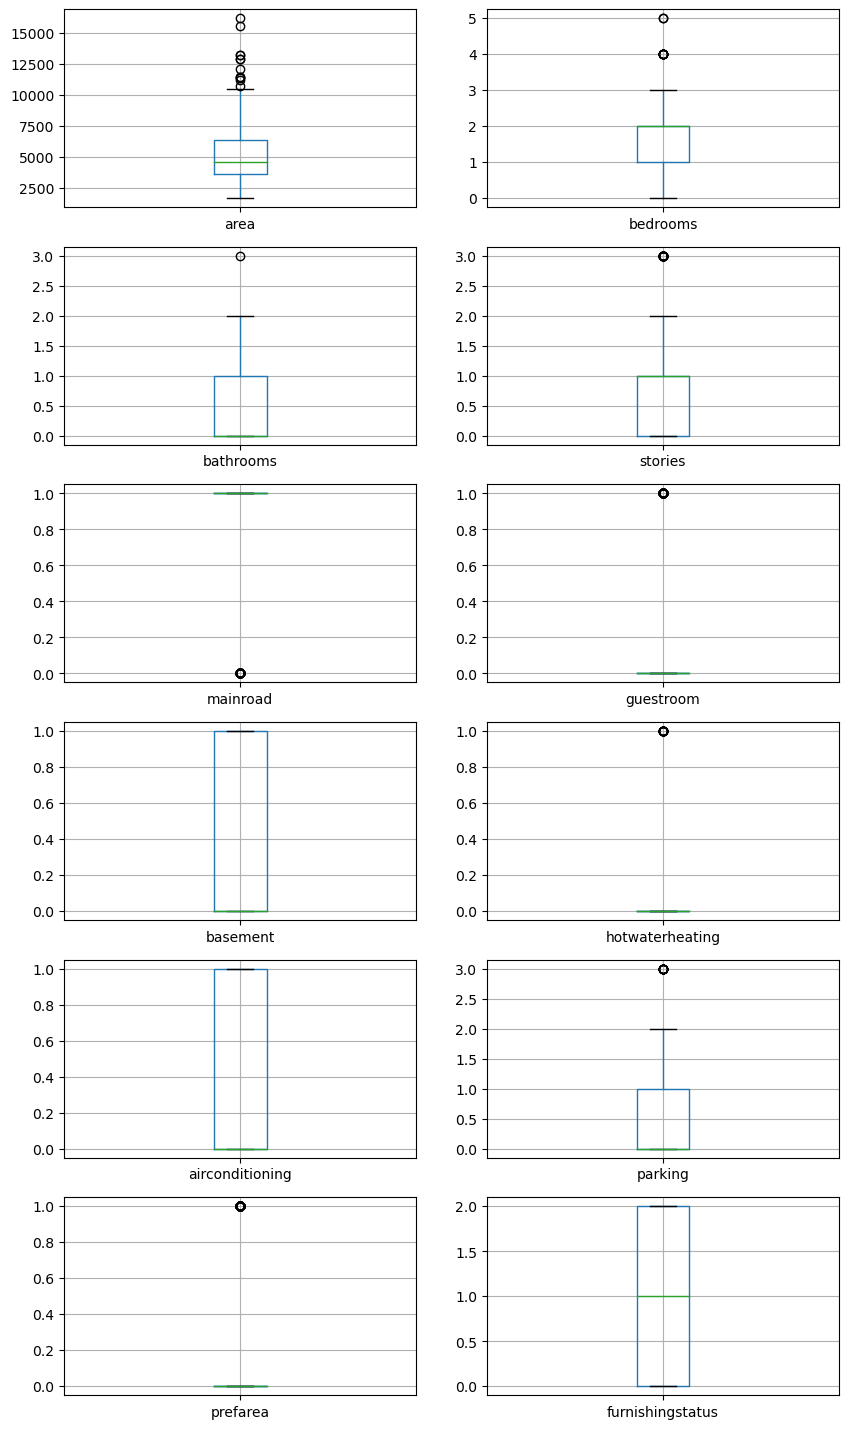

In [16]:
# Detect features with outliers
plt.figure(figsize=[10,3*math.ceil(len(features)/2)])
for i in range(len(features)):
    plt.subplot(math.ceil(len(features)/2),2,i+1)
    df.boxplot(features[i])
        
plt.show()

In [17]:
# Remove Outliers
for i in features:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df[df[i] <= (Q3+(1.5*IQR))]
    df1 = df[df[i] >= (Q1-(1.5*IQR))]
    df1 = df.reset_index(drop=True)
    
print('The Datset consists of {} columns & {} samples.\n'.format(df.shape[1], df.shape[0]))

The Datset consists of 13 columns & 545 samples.



## 3. Data Manipulation

This step involves transforming and organizing data to make it easier to analyze and interpret. 

### a. Splitting

In [18]:
# Split data into training and testing data
X = df[features]
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Training dataset:',Train_X.shape,Train_Y.shape)
print('Testing set:', Test_X.shape, Test_Y.shape)

Training dataset: (436, 12) (436,)
Testing set: (109, 12) (109,)


### b. Scaling

In [19]:
std = StandardScaler()
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
print('Standardardization on Training set\n')
print(Train_X_std.describe())

Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
print('\nStandardardization on Testing set\n')
print(Test_X_std.describe())

Standardardization on Training set

               area      bedrooms     bathrooms       stories      mainroad  \
count  4.360000e+02  4.360000e+02  4.360000e+02  4.360000e+02  4.360000e+02   
mean   4.481634e-17  7.639149e-17 -2.851949e-17 -6.518741e-17 -1.588943e-16   
std    1.001149e+00  1.001149e+00  1.001149e+00  1.001149e+00  1.001149e+00   
min   -1.540198e+00 -2.665645e+00 -5.798966e-01 -9.290231e-01 -2.503331e+00   
25%   -7.389912e-01 -1.293483e+00 -5.798966e-01 -9.290231e-01  3.994677e-01   
50%   -2.933591e-01  7.867901e-02 -5.798966e-01  2.055821e-01  3.994677e-01   
75%    5.932510e-01  7.867901e-02  1.410929e+00  2.055821e-01  3.994677e-01   
max    5.144981e+00  4.195165e+00  5.392582e+00  2.474792e+00  3.994677e-01   

          guestroom    basement  hotwaterheating  airconditioning  \
count  4.360000e+02  436.000000     4.360000e+02     4.360000e+02   
mean  -8.148426e-18    0.000000    -4.481634e-17     4.787200e-17   
std    1.001149e+00    1.001149     1.001149e

## 4. Feature Engineering

This step involves creating or transforming features to improve the model's predictive power.

<Axes: >

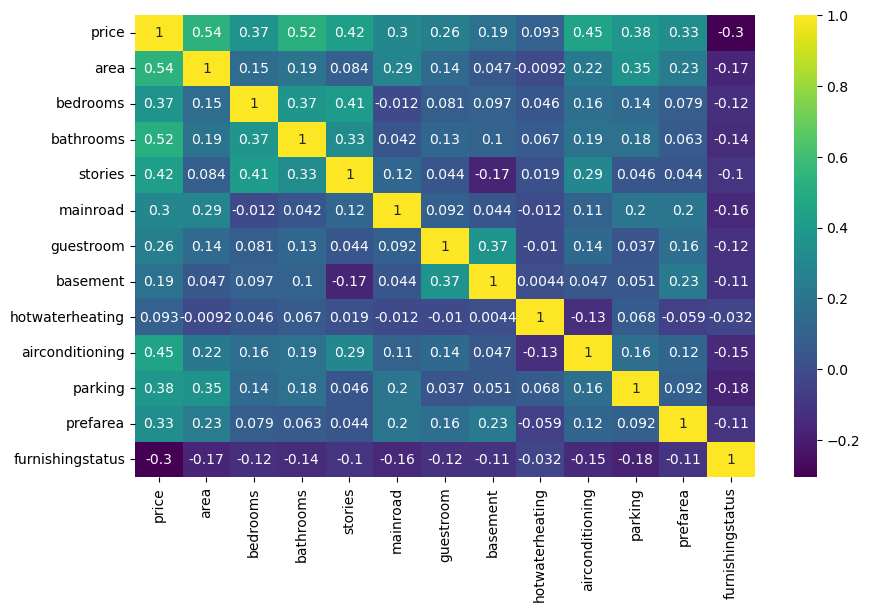

In [20]:
sns.heatmap(df.corr(), cmap='viridis',annot=True)

Above heatmap indicates multi-correlation between the features.

In [21]:
#Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     74.00
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           6.90e-96
Time:                        23:42:21   Log-Likelihood:                -6667.4
No. Observations:                 436   AIC:                         1.336e+04
Df Residuals:                     423   BIC:                         1.341e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         4.796e+06   5.15e+04     93.099      0.000    4.69e+06     4.9e+06
area              5.191e+05   5.94e+04      8.744      0.000    4.02e+05    6.36e+05
bedrooms           6.82e+04   6.05e+04      1.127      0.260   -5.07e+04    1.87e+05
bathrooms          5.72e+05   5.88e+04      9.721      0.000    4.56e+05    6.88e+05
stories           3.579e+05   6.29e+04      5.689      0.000    2.34e+05    4.82e+05
mainroad          1.984e+05   5.59e+04      3.549      0.000    8.85e+04    3.08e+05
guestroom         1.448e+05   5.69e+04      2.547      0.011    3.31e+04    2.57e+05
basement          1.353e+05   5.92e+04      2.286      0.023     1.9e+04    2.52e+05
hotwaterheating   1.968e+05   5.28e+04      3.729      0.000    9.31e+04    3.01e+05
airconditioning   3.836e+05   5.65e+04      6.790      0.000    2.73e+05    4.95e+05
parking           2.109e+05   5.64e+04      3.741      0.000       1e+05    3.22e+05
prefarea          2.543e+05   5.46e+04      4.655      0.000    1.47e+05    3.62e+05
furnishingstatus -1.674e+05   5.34e+04     -3.133      0.002   -2.72e+05   -6.24e+04
==============================================================================
Omnibus:                       78.137   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.253
Skew:                           0.875   Prob(JB):                     4.44e-45
Kurtosis:                       5.860   Cond. No.                         2.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Multicollinerity can resolved using following techniques:

1. Dropping variables
2. Test with Variance Inflation Factors (VIF)
3. Using principal component analysis (PCA)

Commonly used method is PCA.

### Using principal component analysis (PCA)

In [33]:
def pca_predict(data):
    # Calculate the principal components
    pca = PCA(n_components=data.shape[1])
    principal_components = pca.fit_transform(data)

    # Select a subset of principal components
    selected_components = principal_components[:, :5]  # Select the first 5 principal components

    # Use the selected principal components as features for your regression model
    data_without_multicollinearity = pd.DataFrame(selected_components, columns=[features[:5]])
    
    print(data_without_multicollinearity.head(5))
    
print('Removal of multicollinearity in Training set')
pca_predict(Train_X_std)
print('Removal of multicollinearity in Testing set')
pca_predict(Test_X_std)

Removal of multicollinearity in Training set
       area  bedrooms bathrooms   stories  mainroad
0  1.741439  2.092972  0.621163 -0.051186  1.812558
1  2.492050 -1.332716 -0.282046 -1.653815 -1.144468
2  1.181520  3.500579  0.134063  0.484448  0.359980
3  1.005436  1.802216  0.195373 -0.976799  0.175914
4  0.389710 -0.871238 -1.417438  0.697294  0.455978
Removal of multicollinearity in Testing set
       area  bedrooms bathrooms   stories  mainroad
0 -0.515925  0.262313 -0.399696  0.316669  0.016086
1  1.655531 -0.335431 -0.342819 -1.304867 -0.705968
2  0.881262  0.014812 -1.388654  1.817536  2.245253
3  0.989985  2.308587 -0.083022 -0.839260  0.514028
4  0.176757 -1.537793  0.074580 -0.966761 -0.113571


## 5. Model training

In [44]:
# Models for prediction
models = {
    'Multiple Linear Regression': LinearRegression(),
    'Ridge Regression' : Ridge(),
    'Lasso Regression' : Lasso(),
    'Elastic-Net Regression': ElasticNet(),
    'Random Forest Regressor' : RandomForestRegressor(),
    'Gradient Boost Regressor' : GradientBoostingRegressor(),
}

In [47]:
Pred ={}

# Fitting data to different models
for name, mod in models.items():
    mod.fit(Train_X, Train_Y)
    Pred1 = mod.predict(Train_X)
    Pred2 = mod.predict(Test_X)
    Pred[name]=[Pred1,Pred2]

## 6. Model evaluation

In [71]:
#Let us first define a function to evaluate our models

Eval_Matrix = pd.DataFrame(np.zeros([5,6]), columns=['Train-R2','Test-R2','Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,1,replace=False)
r2 = []
mse = []
rmse = []
r2_test = []
mse_test = []
rmse_test = []

def Evaluate(n,name, pred1,pred2):
    #Plotting predicted predictions alongside the actual datapoints 
    print('\033[1mEvaluation of',name)
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Model
    r2.append(round(r2_score(Train_Y, pred1),20))
    mse.append(round(mean_squared_error(Train_Y, pred1),20))
    rmse.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))
    r2_test.append(round(r2_score(Test_Y, pred2),20))
    mse_test.append(round(mean_squared_error(Test_Y, pred2),20))
    rmse_test.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    
    print('\n\nTraining Set Metrics:')
    print('\nR2-Score:',r2[n])
    print('Mean Squared Error (MSE):',mse[n])
    print('Root Mean Squared Error (RMSE):',rmse[n])

    print('\nTesting Set Metrics:')
    print('\nR2-Score:',r2_test[n])
    print('Mean Squared Error (MSE):',mse_test[n])
    print('Root Mean Squared Error (RMSE):',rmse_test[n])
    
    Eval_Matrix.loc[n,'Train-R2']  = r2[n]
    Eval_Matrix.loc[n,'Test-R2']   = mse[n]
    Eval_Matrix.loc[n,'Train-MSE'] = rmse[n]
    Eval_Matrix.loc[n,'Test-MSE']  = r2_test[n]
    Eval_Matrix.loc[n,'Train-RMSE']= mse_test[n]
    Eval_Matrix.loc[n,'Test-RMSE'] = rmse_test[n]
    
    # Plotting y_test and y_pred to understand the spread.
    print('\n\nResidual Plots:')
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

Evaluation of Multiple Linear Regression


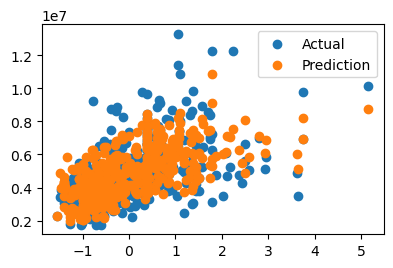



Training Set Metrics:

R2-Score: 0.6773324472457776
Mean Squared Error (MSE): 1122425234816.1912
Root Mean Squared Error (RMSE): 1059445.7205615544

Testing Set Metrics:

R2-Score: 0.6763309062082214
Mean Squared Error (MSE): 1142383874558.4373
Root Mean Squared Error (RMSE): 1068823.593750829


Residual Plots:


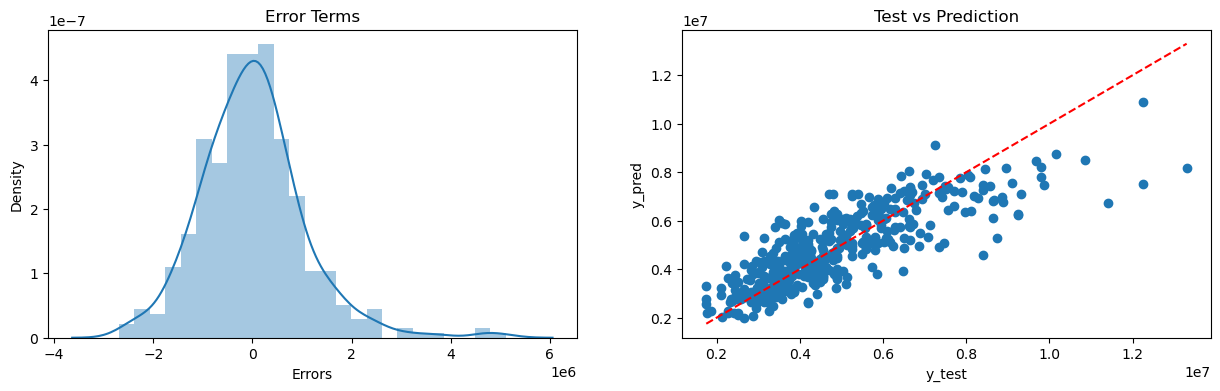

Evaluation of Ridge Regression


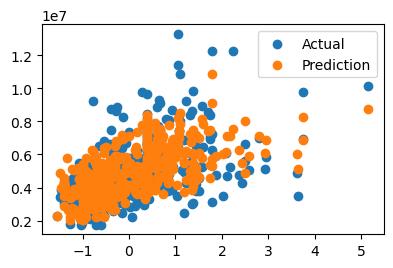



Training Set Metrics:

R2-Score: 0.6772897022445112
Mean Squared Error (MSE): 1122573926767.6255
Root Mean Squared Error (RMSE): 1059515.8926451388

Testing Set Metrics:

R2-Score: 0.6775670329188571
Mean Squared Error (MSE): 1138020988981.078
Root Mean Squared Error (RMSE): 1066780.6658264284


Residual Plots:


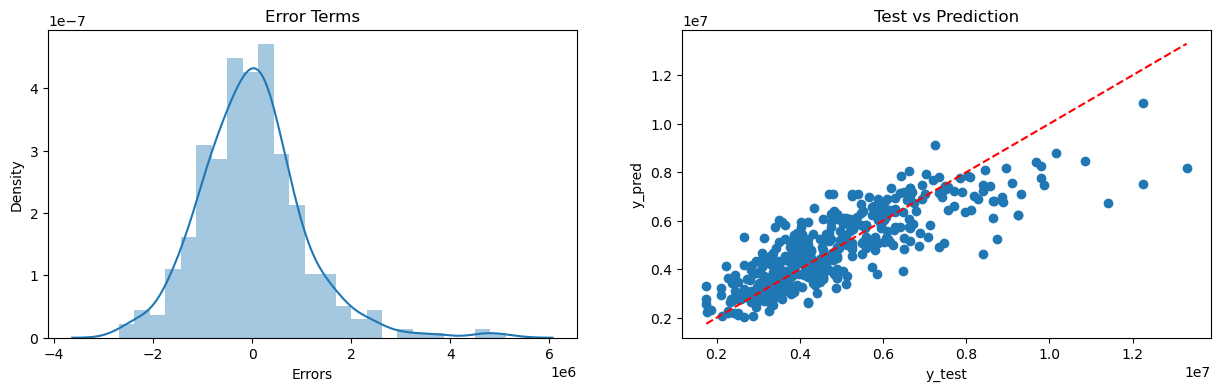

Evaluation of Lasso Regression


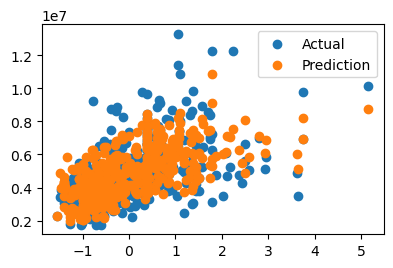



Training Set Metrics:

R2-Score: 0.6773324472320223
Mean Squared Error (MSE): 1122425234864.04
Root Mean Squared Error (RMSE): 1059445.7205841364

Testing Set Metrics:

R2-Score: 0.6763313358010565
Mean Squared Error (MSE): 1142382358318.7444
Root Mean Squared Error (RMSE): 1068822.884447533


Residual Plots:


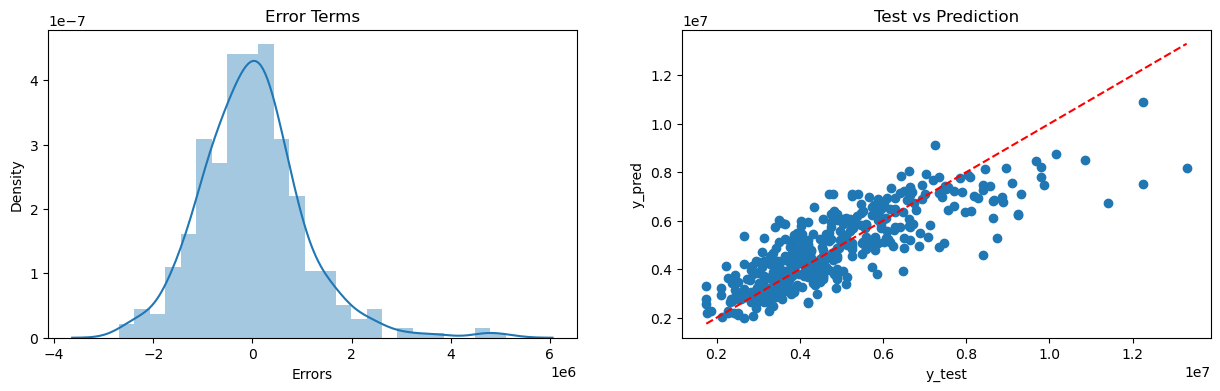

Evaluation of Elastic-Net Regression


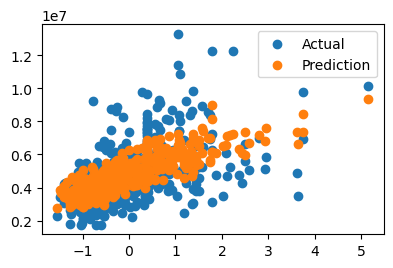



Training Set Metrics:

R2-Score: 0.5751388334467447
Mean Squared Error (MSE): 1477914003321.1106
Root Mean Squared Error (RMSE): 1215694.8643969467

Testing Set Metrics:

R2-Score: 0.6247982395829808
Mean Squared Error (MSE): 1324267435562.0803
Root Mean Squared Error (RMSE): 1150768.1936698114


Residual Plots:


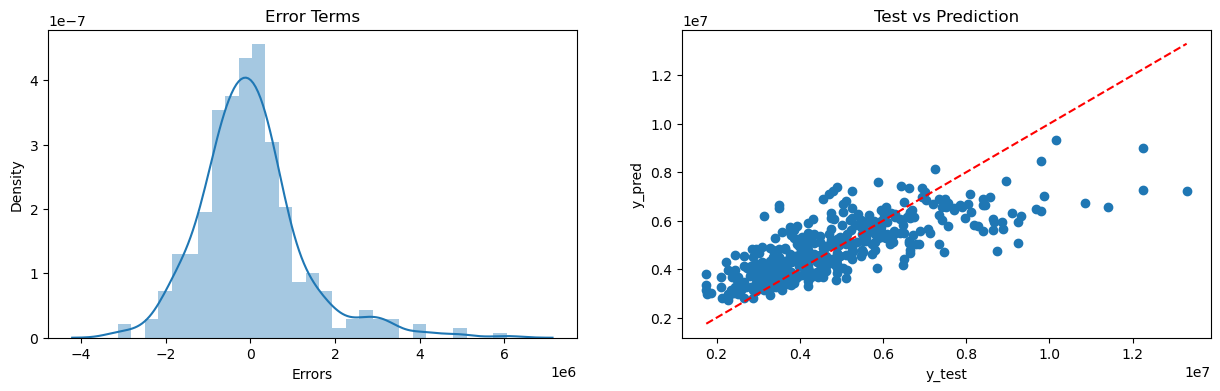

Evaluation of Random Forest Regressor


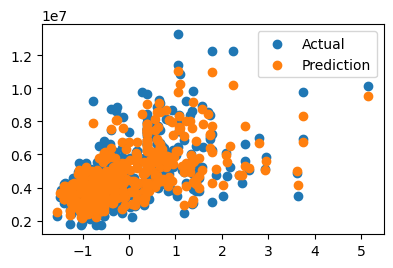



Training Set Metrics:

R2-Score: 0.944869456149978
Mean Squared Error (MSE): 191776065173.6172
Root Mean Squared Error (RMSE): 437922.44196160714

Testing Set Metrics:

R2-Score: 0.6200923373472814
Mean Squared Error (MSE): 1340876827476.3105
Root Mean Squared Error (RMSE): 1157962.3601293396


Residual Plots:


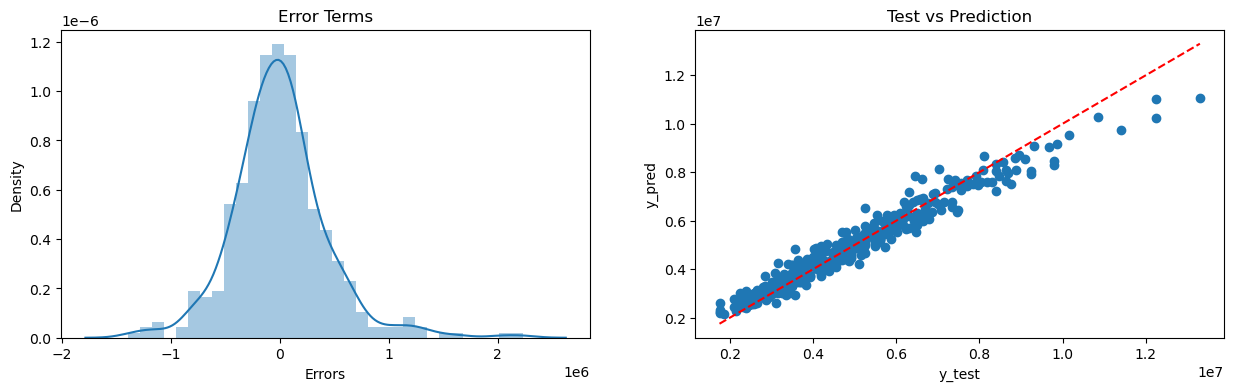

Evaluation of Gradient Boost Regressor


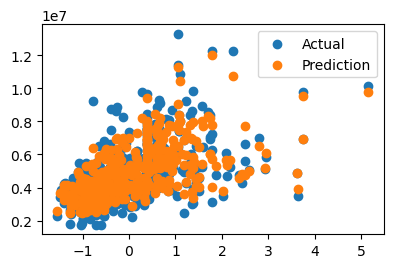



Training Set Metrics:

R2-Score: 0.8546072339576067
Mean Squared Error (MSE): 505760520922.33
Root Mean Squared Error (RMSE): 711168.4195198279

Testing Set Metrics:

R2-Score: 0.7129235124474564
Mean Squared Error (MSE): 1013230970875.082
Root Mean Squared Error (RMSE): 1006593.7466898361


Residual Plots:


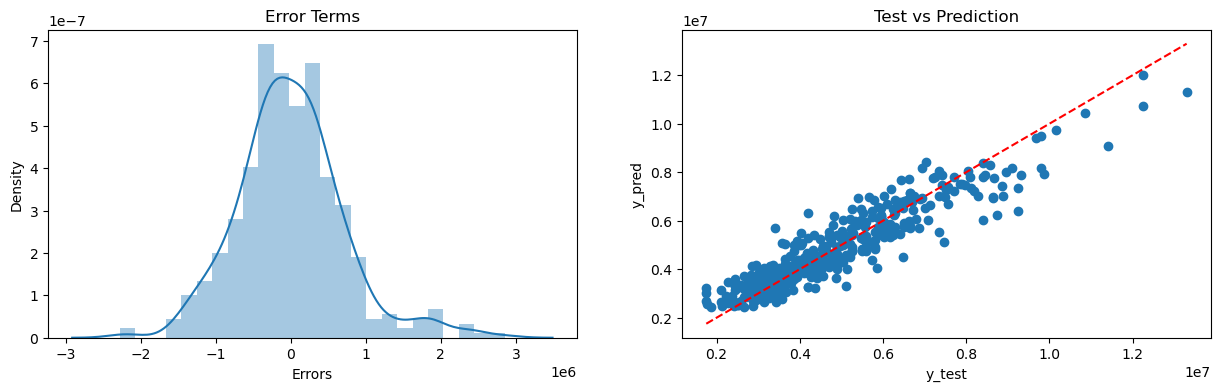

In [72]:
n = 0
# Evaluating the models
for name,pred in Pred.items():
    Evaluate(n,name,pred[0],pred[1])
    n += 1

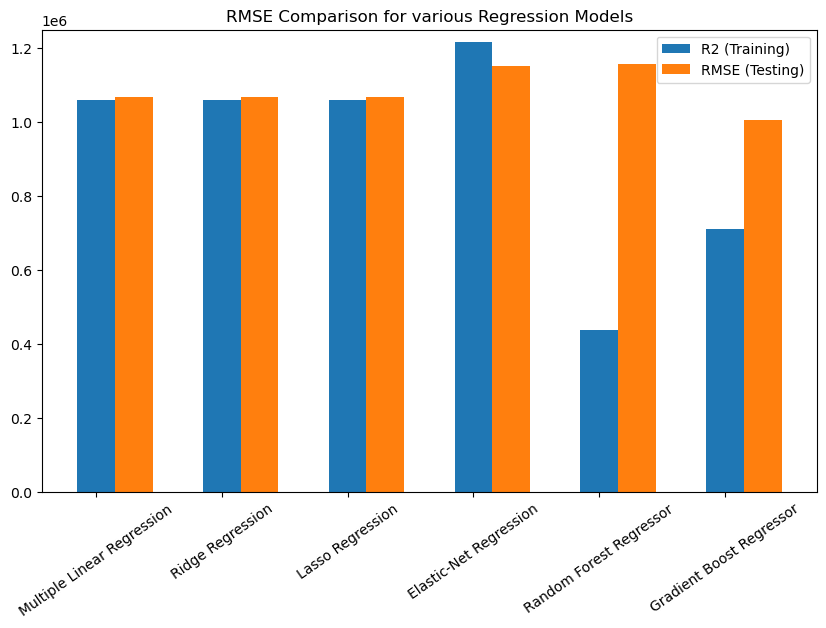

In [80]:
index = ['Multiple Linear Regression','Ridge Regression','Lasso Regression','Elastic-Net Regression','Random Forest Regressor','Gradient Boost Regressor']

def plot_rmse(train, test,label1, label2, title):
    plt.bar(np.arange(6), train, width=0.3, label=label1)
    plt.bar(np.arange(6)+0.3, test, width=0.3, label=label2)
    plt.xticks(np.arange(6), index, rotation =35)
    plt.title(title)
    plt.legend()
    plt.ylim([0,1.25e6])
    plt.show()

plot_rmse
(rmse, rmse_test, 'RMSE (Training)', 'RMSE (Testing)', 'RMSE Comparison for various Regression Models')

***Inference***:Lesser the RMSE, better the model. The above graph indicates least RMSE for Random Forest Regressor. But the RMSE for testing data is the highest. This clearly shows that the model is overfitting. This also applies to Gradient Boost Regressor.

The Multiple Linear Regression, Ridge Regression and Lasso Regression hold similar and best results.

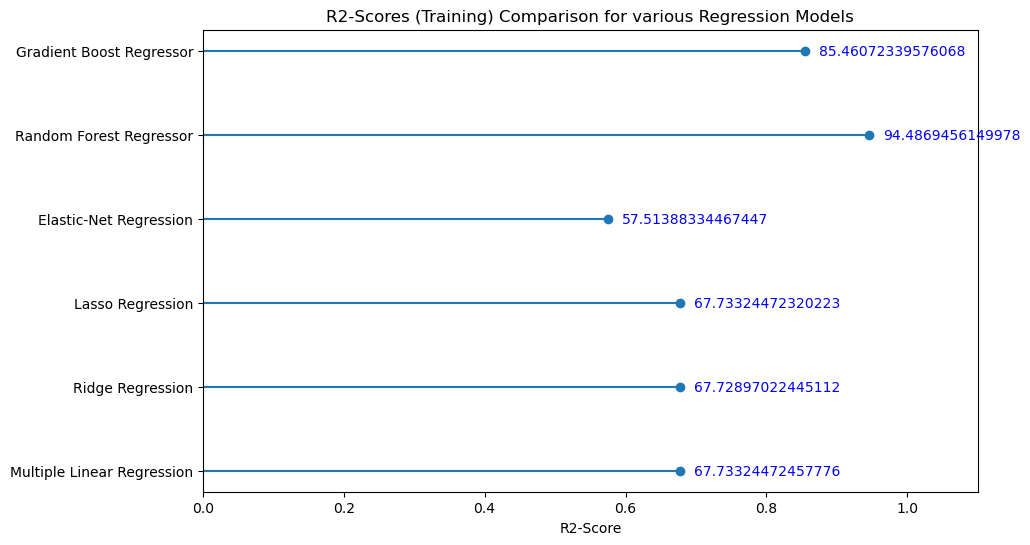

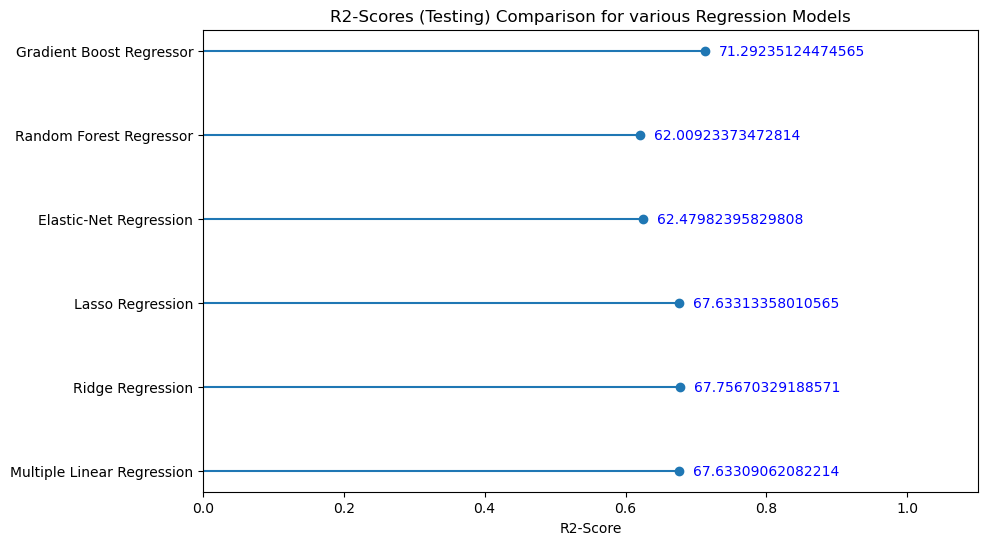

In [82]:
def plot_r2(r2,title):
    plt.hlines(y=index, xmin=0, xmax=r2)
    plt.plot(r2, index,'o')
    plt.title(title)
    plt.xlabel('R2-Score')
    for i, v in enumerate(r2):
        plt.text(v+0.02, i-0.05, str(v*100), color='blue')
    plt.xlim([0,1.1])
    plt.show()
    
plot_r2(r2, 'R2-Scores (Training) Comparison for various Regression Models')
plot_r2(r2_test, 'R2-Scores (Testing) Comparison for various Regression Models')

The Multiple Linear Regression, Ridge Regression and Lasso Regression hold similar and consistent R2-Scores, which indicates better explainability power to understand the dataset. 

## Project Outcomes:

Here are some of the key outcomes of the project:
* The Dataset was quiet small with just 13 columns and 545 samples. After data processing 533 samples were retained.
* The features had high multicollinearity and was removed by PCA
* While, Random Forest Regressor and Gradient Boost Regressor were overfitting, yet it is safe to use multiple regression algorithm, as it produced moderate R2-scores and RMSE for both training and testing.
* The Ridge Regression and Lasso Regression performed similar to Multiple Linear regression with R2-Score of 67 approx.